# Algoritmos #
### Introducción ##

Importamos las **librerías** que van a ser necesarias para el desarrollo de las pertinentes acciones en este notebook.

In [1]:
import warnings

from graphviz import Source
from IPython.display import Image
from pandas import Series, DataFrame
from scipy.interpolate import interp1d
from scipy.stats import*
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import tree, datasets, svm
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import ast
import calendar
import csv
import geocoder
import math
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pydot
import pydotplus
import reverse_geocoder as rg
import scipy.fftpack
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import time

C:\Users\grane\Anaconda3\envs\granero\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 100)
inicio = time.strftime("%c")
%matplotlib inline

In [3]:
df_ori = pd.read_csv('.././PreparacionData/dataCleaning.csv', sep = '|', low_memory=False, parse_dates=[['FECHA','TIEMPO']])
df_ori.head()

,FECHA_TIEMPO,ID,AREA,CODIGO_POSTAL,LATITUD,LONGITUD,LOCALIZACION,CALLE1,CALLE2,CALLE3,PERSONA_LESIONADA,PERSONA_MUERTA,PEATON_LESIONADO,PEATON_MUERTO,CICLISTA_LESIONADO,CICLISTA_MUERTO,MOTORISTA_LESIONADO,MOTORISTA_MUERTO,VEHICULO1,VEHICULO2,VEHICULO3,VEHICULO4,VEHICULO5,FACTOR1,FACTOR2,FACTOR3,FACTOR4,FACTOR5
0,2015-01-01 00:20:00,3146911,QUEENS,11358.0,40.751847,-73.787862,"(40.7518471, -73.787862)",47 AVENUE,193 STREET,NaN,0,0,0,0,0,0,0,0,SPORT UTILITY/STATION WAGON,NaN,NaN,NaN,NaN,TRAFFIC CONTROL DISREGARDED,NaN,NaN,NaN,NaN
1,2015-01-01 00:20:00,3146180,MANHATTAN,NaN,40.771289,-73.946693,"(40.7712888, -73.9466928)",NaN,NaN,NaN,1,0,0,0,0,0,1,0,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,ANIMALS ACTION,NaN,NaN,NaN,NaN
2,2015-01-01 00:21:00,3146384,BROOKLYN,11205.0,40.689445,-73.955121,"(40.6894449, -73.9551212)",BEDFORD AVENUE,LAFAYETTE AVENUE,NaN,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN,FATIGUED/DROWSY,UNSPECIFIED,NaN,NaN,NaN
3,2015-01-01 00:30:00,3146013,BROOKLYN,11213.0,40.673845,-73.925080,"(40.6738445, -73.9250801)",BUFFALO AVENUE,SAINT MARKS AVENUE,NaN,0,0,0,0,0,0,0,0,BUS,PASSENGER VEHICLE,NaN,NaN,NaN,LOST CONSCIOUSNESS,NaN,NaN,NaN,NaN
4,2015-01-01 00:33:00,3146120,STATEN ISLAND,10301.0,NaN,NaN,NaN,RICHMOND TERRACE,SOUTH AVENUE,NaN,0,0,0,0,0,0,0,0,UNKNOWN,PASSENGER VEHICLE,NaN,NaN,NaN,UNSPECIFIED,UNSPECIFIED,NaN,NaN,NaN


In [4]:
df = df_ori.copy()
df['DIASEMANA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.dayofweek
df['HORA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.hour
df['MES'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.month
df['DIA'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.day
df['AÑO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.year
df['MINUTO'] = pd.to_datetime(df['FECHA_TIEMPO']).dt.minute

# Método Supervisado

### Regresión

Para el análisis mediante métodos supervisados, he decidido filtrar el dataframe para los años 2015 y 2016, ya que para el año 2017 la muestra de datos solo contempla hasta el día **28 de febrero de 2017(2 meses)**.

In [5]:
df['FECHA_TIEMPO'].max()

Timestamp('2017-02-28 23:36:00')

In [6]:
df_2015 = df[df['AÑO'] == 2015]
df_2016 = df[df['AÑO'] == 2016]

In [7]:
df.columns

Index(['FECHA_TIEMPO', 'ID', 'AREA', 'CODIGO_POSTAL', 'LATITUD', 'LONGITUD',
       'LOCALIZACION', 'CALLE1', 'CALLE2', 'CALLE3', 'PERSONA_LESIONADA',
       'PERSONA_MUERTA', 'PEATON_LESIONADO', 'PEATON_MUERTO',
       'CICLISTA_LESIONADO', 'CICLISTA_MUERTO', 'MOTORISTA_LESIONADO',
       'MOTORISTA_MUERTO', 'VEHICULO1', 'VEHICULO2', 'VEHICULO3', 'VEHICULO4',
       'VEHICULO5', 'FACTOR1', 'FACTOR2', 'FACTOR3', 'FACTOR4', 'FACTOR5',
       'DIASEMANA', 'HORA', 'MES', 'DIA', 'AÑO', 'MINUTO'],
      dtype='object')

Vamos a realizar el análisis sobre el grupo de personas dañadas o lesionadas en las colisiones (recordar que este grupo es un conjunto tanto de los peatones, como ciclistas y motoristas) por la hora del día.
Elegimos manualmente un conjunto de 15 registros sobre la muestra para ambos años.

In [8]:
grupo = 'PERSONA_LESIONADA'
df_2015_H = df_2015.groupby(df_2015['HORA']).sum()[[grupo]]
df_2016_H = df_2016.groupby(df_2016['HORA']).sum()[[grupo]]
X=[2,3,5,7,9,10,11,12,13,14,15,19,20,22]


In [9]:
Y15_df=[]
for x in X:
    Y15_df.append(df_2015_H[grupo][x])
Y16_df=[]
for x in X:
    Y16_df.append(df_2016_H[grupo][x])

Incorporamos los registros en una gráfica para ver la distribución de estos.

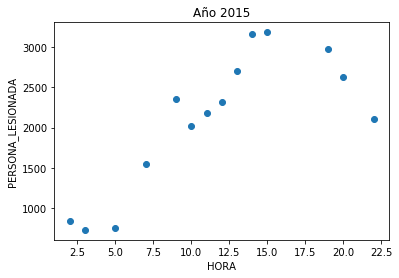

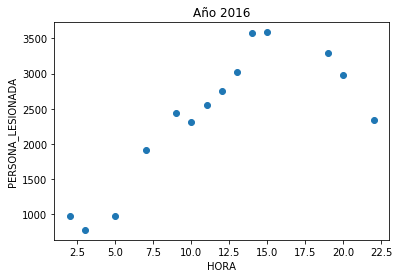

In [10]:
co=0
for x in [Y15_df,Y16_df]:
    plt.scatter(X,x)
    if(co == 0):
        nom = '2015'
        numer=1
    else:
        nom ='2016'
        numer=2
    plt.title('Año ' + str(nom))
    plt.xlabel('HORA')
    plt.ylabel(grupo)
    co += 1
    plt.savefig('.././Imagenes/AS/AS_IMAGEN'+str(numer)+'.png', bbox_inches='tight')
    plt.show()

Para poder obtener la línea que mejor se adapte a nuestra muesta usaremos el algoritmo **LSM**(Least Sqared Method).

Usando la curva del mejor entrenamiento podemos predecir la salida desconocida para una entrada X.
Para resolver la salida entrenada, necesitaremos los diferentes de los coeficientes dependiendo del grado de la función. Estos coeficientes que en la fórmula siguiente equivalen a los caracteres: "a,b,c,d", se van a calcular mediante el metodo **polyfit**.
Una vez que hayamos obtenidos estos, deberemos reemplazar los valores para resolver la salida entrenada(**Yfit**).
Para resolver la salida usamos el método **polyval**.

La ecuación para la curva para **grado 3** es: $$ Yfit=ax^{3}+bx^{2}+cx+d $$


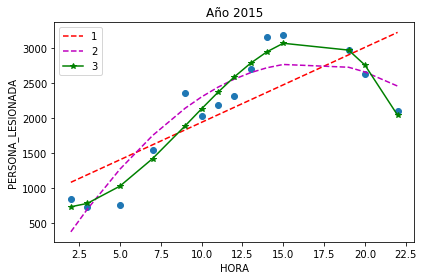

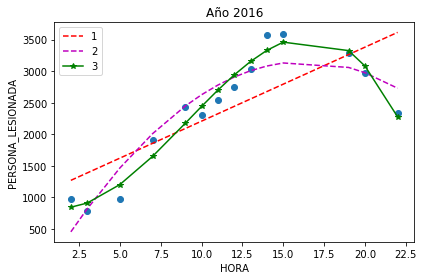

In [11]:
co=0
for x in [Y15_df,Y16_df]:
    if(co == 0):
        p115= np.polyfit(X,x,1)
        p215= np.polyfit(X,x,2)
        p315= np.polyfit(X,x,3)
        nom = '2015'
        #plt.grid(True)
        plt.scatter(X,x)
        plt.title('Año ' + str(nom))
        plt.xlabel('HORA')
        plt.ylabel(grupo)
        plt.tight_layout()
        plt.plot(X,np.polyval(p115,X), 'r--', label = '1')
        plt.plot(X,np.polyval(p215,X), 'm--', label = '2')
        plt.plot(X,np.polyval(p315,X), 'g*-', label = '3')
        plt.legend(loc="higer right")
        co += 1
        plt.savefig('.././Imagenes/AS/AS_IMAGEN3.png', bbox_inches='tight')
        plt.show()
    else:
        p116= np.polyfit(X,x,1)
        p216= np.polyfit(X,x,2)
        p316= np.polyfit(X,x,3)
        nom ='2016'
        plt.scatter(X,x)
        plt.title('Año ' + str(nom))
        plt.xlabel('HORA')
        plt.ylabel(grupo)
        plt.tight_layout()
        plt.plot(X,np.polyval(p116,X), 'r--', label = '1')
        plt.plot(X,np.polyval(p216,X), 'm--', label = '2')
        plt.plot(X,np.polyval(p316,X), 'g*-', label = '3')
        plt.legend(loc="higer right")
        plt.savefig('.././Imagenes/AS/AS_IMAGEN4.png', bbox_inches='tight')
        plt.show()


Apreciamos como la curva que mejor se adapta coincide con el modelo de **3er grado**.

Para poder observar del método sobre la muestra elegida, generamos un dataframe en donde establecemos como cantidad el **%** de la diferencia entre ellas.

In [12]:
df_2015_H['PREDICION_'+grupo+'_2015']=0
df_2015_H['PRECISION_'+grupo+'_2015(%)']=0
df_2016_H['PREDICION_'+grupo+'_2016']=0
df_2016_H['PRECISION_'+grupo+'_2016(%)']=0
for x in range(len(df_2015_H)):
    df_2015_H['PREDICION_'+grupo+'_2015'][x]= np.polyval(p315,x)
    if df_2015_H[grupo][x] != 0:
        df_2015_H['PRECISION_'+grupo+'_2015(%)'][x]= np.polyval(p315,x)/df_2015_H[grupo][x]*100
for x in range(len(df_2016_H)):
    df_2016_H['PREDICION_'+grupo+'_2016'][x]= np.polyval(p316,x)
    if df_2016_H[grupo][x] != 0:
        df_2016_H['PRECISION_'+grupo+'_2016(%)'][x]= np.polyval(p316,x)/df_2016_H[grupo][x]*100

El primer valor de **59** refiere a que la diferencia entre el valor real y la predicción es del **59%** siendo menor la predición, mientras que por ejemplo para valores que sobrepasen el **100%** como puede ser la cuarta muestra(**108**), la predición ha sobrepasado un **8%** la muestra real.

In [13]:
df_2015_H[[grupo,'PREDICION_'+grupo+'_2015','PRECISION_'+grupo+'_2015(%)']].head()

,PERSONA_LESIONADA,PREDICION_PERSONA_LESIONADA_2015,PRECISION_PERSONA_LESIONADA_2015(%)
HORA,,,
0,1451,838,57
1,1002,752,75
2,842,737,87
3,734,784,106
4,863,885,102


In [14]:
df_2016_H[[grupo,'PREDICION_'+grupo+'_2016','PRECISION_'+grupo+'_2016(%)']].head()

,PERSONA_LESIONADA,PREDICION_PERSONA_LESIONADA_2016,PRECISION_PERSONA_LESIONADA_2016(%)
HORA,,,
0,2172,924,42
1,1167,847,72
2,982,846,86
3,779,911,117
4,1033,1034,100


** Vamos a calcular el coeficiente de determinación para poder determinar la calidad del modelo para replicar los resultados.
**
<br>Recordar que  $ R^2 $ está delimitado entre $ {0,1} $

Además podemos hayar tambien el error estándar, siendo este la desviación de la distribución muestral de un estadístico, es decir, **la derivada de una muestra particular usada para la estimación**.

In [15]:
slope15,intercept15,r_value15,p_value15,std_err15=linregress(X,Y15_df)
slope16,intercept16,r_value16,p_value16,std_err16=linregress(X,Y16_df)
print('El coeficiente de correlación para el año 2015: {a} \nEl error estandar para el año 2015: {b}'
      .format(a=pow(r_value15,2), b=std_err15))
print('\nEl coeficiente de correlación para el año 2016: {a} \nEl error estandar para el año 2016: {b}'
      .format(a=pow(r_value16,2), b=std_err16))

El coeficiente de correlación para el año 2015: 0.6010703058968174 
El error estandar para el año 2015: 25.121660570065316

El coeficiente de correlación para el año 2016: 0.5956757465282643 
El error estandar para el año 2016: 27.863602041077208


Vamos a realizar un estudio comparativo por los años y por la cantidad de muestras. 

Por lo que deberemos realizar de nuevo el cálculo de la regresión pero para la muestra completa.

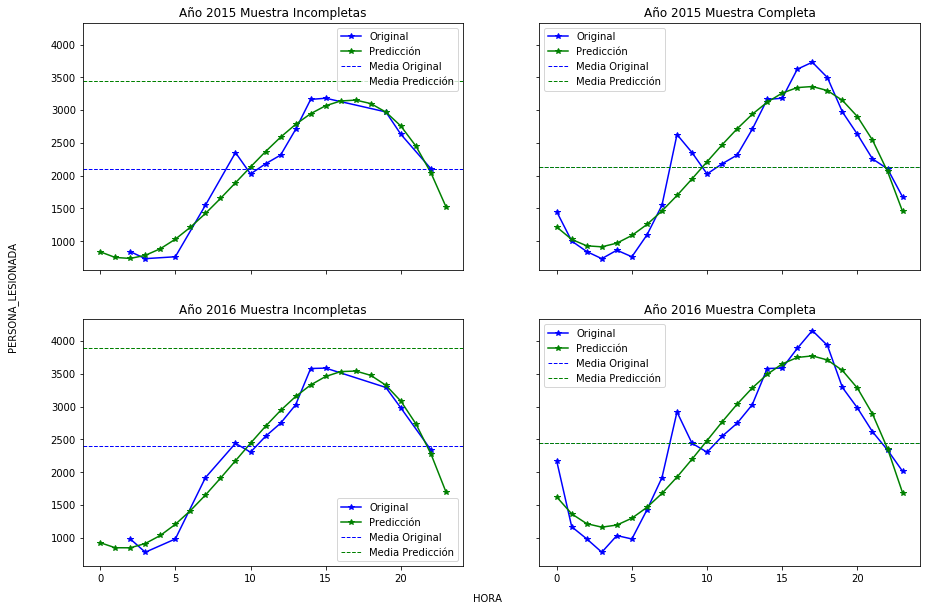

In [16]:

x_fit = np.arange(24)
y_fit15,y_fit16,y_fit15f,y_fit16f  = [],[],[],[]

Y15_ori,Y16_ori=[],[]
for x in x_fit:
    Y15_ori.append(df_2015_H[grupo][x])
    Y16_ori.append(df_2016_H[grupo][x])
    
p315f= np.polyfit(x_fit,Y15_ori,3)
p316f= np.polyfit(x_fit,Y16_ori,3)

for i in range(len(x_fit)):
    y_fit15f.append(np.polyval(p315f, i))
    y_fit16f.append(np.polyval(p316f, i))
    y_fit15.append(np.polyval(p315, i))
    y_fit16.append(np.polyval(p316, i))

media15OI,media16OI = 0,0
for row in range(len(X)):
    media15OI += Y15_df[row]
    media16OI += Y16_df[row]
    
media15OI=media15OI/len(X)
media16OI=media16OI/len(X)

media15PI,media16PI,media15OC,media16OC,media15PC,media16PC = 0,0,0,0,0,0
for row in range(len(x_fit)):
    media15PI += y_fit15[row]
    media16PI += y_fit16[row]
    media15OC += Y15_ori[row]
    media16OC += Y16_ori[row]
    media15PC += y_fit15f[row]
    media16PC += y_fit16f[row]
    
media15PI=media15PI/len(X)
media16PI=media16PI/len(X)
media15OC=media15OC/len(x_fit)
media16OC=media16OC/len(x_fit)
media15PC=media15PC/len(x_fit)
media16PC=media16PC/len(x_fit)    
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10) , sharex=True, sharey=True)
#ax1.grid(True)
ax1.plot(X, Y15_df, 'b*-', label = "Original")
ax1.plot(x_fit, y_fit15, 'g*-', label = "Predicción")
ax1.title.set_text('Año 2015 Muestra Incompletas')
ax1.axhline(media15OI, linestyle='dashed', linewidth=1, color='b', label='Media Original')
ax1.axhline(media15PI, linestyle='dashed', linewidth=1, color='g', label='Media Predicción')
ax1.legend(loc="higer right")

ax3.plot(X, Y16_df, 'b*-',label = "Original")
ax3.plot(x_fit, y_fit16, 'g*-', label = "Predicción")
ax3.title.set_text('Año 2016 Muestra Incompletas')
ax3.axhline(media16OI, linestyle='dashed', linewidth=1, color='b', label='Media Original')
ax3.axhline(media16PI, linestyle='dashed', linewidth=1, color='g', label='Media Predicción')
ax3.legend(loc="higer right")

ax2.plot(x_fit, Y15_ori, 'b*-', label = "Original")
ax2.plot(x_fit, y_fit15f, 'g*-', label = "Predicción")
ax2.title.set_text('Año 2015 Muestra Completa')
ax2.axhline(media15OC, linestyle='dashed', linewidth=1, color='b', label='Media Original')
ax2.axhline(media15PC, linestyle='dashed', linewidth=1, color='g', label='Media Predicción')
ax2.legend(loc="higer right")

ax4.plot(x_fit, Y16_ori, 'b*-',label = "Original")
ax4.plot(x_fit, y_fit16f, 'g*-', label = "Predicción")
ax4.title.set_text('Año 2016 Muestra Completa')
ax4.axhline(media16OC, linestyle='dashed', linewidth=1, color='b', label='Media Original')
ax4.axhline(media16PC, linestyle='dashed', linewidth=1, color='g', label='Media Predicción')
ax4.legend(loc="higer right")

fig.text(0.5, 0.08, 'HORA', ha='center', va='center')
fig.text(0.06, 0.5, grupo, ha='center', va='center', rotation='vertical')
plt.savefig('.././Imagenes/AS/AS_IMAGEN5.png', bbox_inches='tight')
plt.show()

Puede apreciar 4 gráficas. 

Las localizadas en la parte izquierda corresponden a las muestras incompletas. 

Podemos ver de manera gráfica con las vistas superiores como a modo más específico, la relación de la media de ponderaciones entre las muestras originales y predictivas.
La relación para las muestras completas son equitativas, mientras que tanto para las graficas con muestras incompletas, la relación es aproximadamente 1.6 veces mayor la predición.

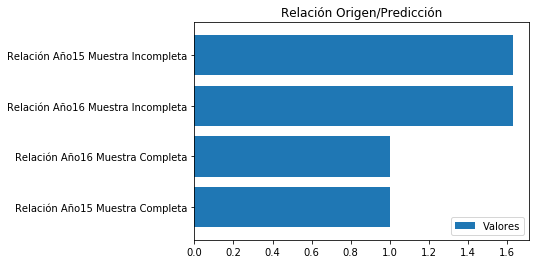

In [17]:
mvalues,values = [],[]
mvalues = ['Relación Año15 Muestra Incompleta','Relación Año16 Muestra Incompleta','Relación Año15 Muestra Completa','Relación Año16 Muestra Completa']
values = [media15PI/media15OI,media16PI/media16OI,media15PC/media15OC,media16PC/media16OC]
rel = pd.DataFrame({'Medias': mvalues,'Valores': values},index=mvalues)

rel.sort_values('Valores',ascending=True).plot(kind='barh',color='#1F77B4',width=0.8,title='Relación Origen/Predicción')
plt.savefig('.././Imagenes/AS/AS_IMAGEN6.png', bbox_inches='tight')
plt.show()

Podemos desagregar las medidas de forma más óptima para apreciar que tipo de muestra para cada registro proporciona el valor más preciso.

In [18]:
y_15, y_16, tipo_mu15, tipo_mu16 = [],[],[],[]
for x in np.arange(24):
    if np.absolute(Y15_ori[x]-y_fit15[x]) < np.absolute(Y15_ori[x]-y_fit15f[x]):
        print('Año 2015 --> Para la muestra {a} con valor {e},el dataset con muestra incompleta {c} fue más precisa que con la muestra completa {d}, desviándose {b}u.'.format(a=x,c=math.trunc(y_fit15[x]),d=math.trunc(y_fit15f[x]),e=Y15_ori[x],b=np.absolute(math.trunc(Y15_ori[x]-y_fit15[x]))))
        y_15.append(np.absolute(math.trunc(Y15_ori[x]-y_fit15[x])))
        tipo_mu15.append('Incompleta')
    if np.absolute(Y15_ori[x]-y_fit15[x]) >= np.absolute(Y15_ori[x]-y_fit15f[x]):
        print('Año 2015 --> Para la muestra {a} con valor {e},el dataset con muestra completa {d} fue más precisa que con la muestra incompleta {c}, desviándose {b}u.'.format(a=x,c=math.trunc(y_fit15[x]),d=math.trunc(y_fit15f[x]),e=Y15_ori[x],b=np.absolute(math.trunc(Y15_ori[x]-y_fit15f[x]))))
        y_15.append(np.absolute(math.trunc(Y15_ori[x]-y_fit15f[x])))
        tipo_mu15.append('Completa')
    if np.absolute(Y16_ori[x]-y_fit16[x]) < np.absolute(Y16_ori[x]-y_fit16f[x]):
        print('Año 2016 --> Para la muestra {a} con valor {e},el dataset con muestra incompleta {c} fue más precisa que con la muestra completa {d}, desviándose {b}u.'.format(a=x,c=math.trunc(y_fit16[x]),d=math.trunc(y_fit16f[x]),e=Y16_ori[x],b=np.absolute(math.trunc(Y16_ori[x]-y_fit16[x]))))
        y_16.append(np.absolute(math.trunc(Y16_ori[x]-y_fit16[x])))   
        tipo_mu16.append('Incompleta')
    if np.absolute(Y16_ori[x]-y_fit16[x]) >= np.absolute(Y16_ori[x]-y_fit16f[x]):
        print('Año 2016 --> Para la muestra {a} con valor {e},el dataset con muestra completa {d} fue más precisa que con la muestra incompleta {c}, desviándose {b}u.'.format(a=x,c=math.trunc(y_fit16[x]),d=math.trunc(y_fit16f[x]),e=Y16_ori[x],b=np.absolute(math.trunc(Y16_ori[x]-y_fit16f[x]))))
        y_16.append(np.absolute(math.trunc(Y16_ori[x]-y_fit16f[x])))
        tipo_mu16.append('Completa')


Año 2015 --> Para la muestra 0 con valor 1451,el dataset con muestra completa 1216 fue más precisa que con la muestra incompleta 838, desviándose 234u.
Año 2016 --> Para la muestra 0 con valor 2172,el dataset con muestra completa 1622 fue más precisa que con la muestra incompleta 924, desviándose 549u.
Año 2015 --> Para la muestra 1 con valor 1002,el dataset con muestra completa 1026 fue más precisa que con la muestra incompleta 752, desviándose 24u.
Año 2016 --> Para la muestra 1 con valor 1167,el dataset con muestra completa 1363 fue más precisa que con la muestra incompleta 847, desviándose 196u.
Año 2015 --> Para la muestra 2 con valor 842,el dataset con muestra completa 929 fue más precisa que con la muestra incompleta 737, desviándose 87u.
Año 2016 --> Para la muestra 2 con valor 982,el dataset con muestra incompleta 846 fue más precisa que con la muestra completa 1213, desviándose 135u.
Año 2015 --> Para la muestra 3 con valor 734,el dataset con muestra incompleta 784 fue más pr

Los valores medios de dispersión no difieren de más de 200 puntos con respecto a la muestra original para ambos años(esta se deduciría sin el outlier encontrado, por lo que se deduce que se mantiene una relación de los accidentes producidos cada año.

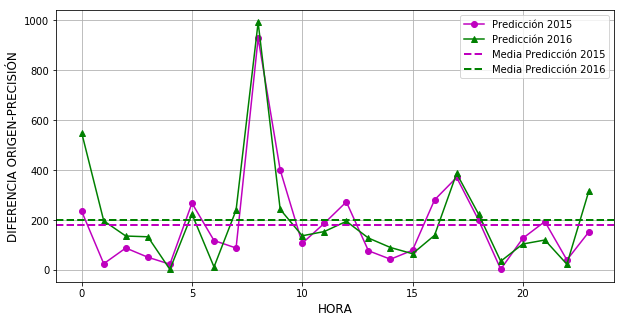

,ORIGEN_15,PREDICCION_15,MUESTRA15,ORIGEN_16,PREDICCION_16,MUESTRA16
0,1451,234,Completa,2172,549,Completa
1,1002,24,Completa,1167,196,Completa
2,842,87,Completa,982,135,Incompleta
3,734,50,Incompleta,779,132,Incompleta
4,863,22,Incompleta,1033,1,Incompleta
5,763,267,Incompleta,981,223,Incompleta
6,1095,117,Incompleta,1424,11,Incompleta
7,1549,87,Completa,1916,239,Completa
8,2627,929,Completa,2918,992,Completa
9,2352,400,Completa,2440,242,Completa


In [19]:
media15,media16 = 0,0
for x in np.arange(24):
    media15 += y_15[x]
    media16 += y_16[x]
media15=media15/24
media16=media16/24

plt.figure(figsize=(10, 5))
plt.grid(True)
plt.xlabel('HORA', fontsize=12)
plt.ylabel('DIFERENCIA ORIGEN-PRECISIÓN', fontsize=12)
plt.plot(np.arange(24),y_15, 'mo-', label = 'Predicción 2015')
plt.plot(np.arange(24),y_16, 'g^-', label = 'Predicción 2016')
plt.axhline(media15, linestyle='dashed', linewidth=2, color='m', label = 'Media Predicción 2015')
plt.axhline(media16, linestyle='dashed', linewidth=2, color='g', label = 'Media Predicción 2016')
plt.legend(loc="higer right")
plt.savefig('.././Imagenes/AS/AS_IMAGEN7.png', bbox_inches='tight')
plt.show()
RESULTADOS = pd.DataFrame({'ORIGEN_15': Y15_ori,'PREDICCION_15': y_15,'MUESTRA15': tipo_mu15, 'ORIGEN_16': Y16_ori,'PREDICCION_16': y_16, 'MUESTRA16': tipo_mu16})
RESULTADOS

In [20]:
slope15,intercept15,r_value15,p_value15,std_err15=linregress(x_fit,Y15_ori)
slope16,intercept16,r_value16,p_value16,std_err16=linregress(x_fit,Y16_ori)
print('El coeficiente de correlación para el año 2015: {a} \nEl error estandar para el año 2015: {b}'
      .format(a=pow(r_value15,2), b=std_err15))
print('\nEl coeficiente de correlación para el año 2016: {a} \nEl error estandar para el año 2016: {b}'
      .format(a=pow(r_value16,2), b=std_err16))

El coeficiente de correlación para el año 2015: 0.4688103461933199 
El error estandar para el año 2015: 20.95345578685524

El coeficiente de correlación para el año 2016: 0.4507808466604554 
El error estandar para el año 2016: 22.744619402910192


Podemos deducir que los resultados son muy equitativos realizando el modelo con las muestras elegidas que con el modelo completo.

### Árbol de decisión

Para usar este tipo de método supervisado, tambien deberemos asegurarnos de que nuestro dataframe no contiene valores **NaN**, por lo que antes de nada despachamos los valores que no aporten valor y nos cercioramos de eliminar aquellos Nulos.

In [21]:
arbol=df.loc[(df['AREA'] != "DESCONOCIDO")& (df['FACTOR1'] !="DESCONOCIDO")& (df['VEHICULO1'] !="DESCONOCIDO")]
arbol['VEHICULO1']=arbol['VEHICULO1'].replace(np.NaN,'DESCONOCIDO')
arbol['AREA']=arbol['AREA'].replace(np.NaN,'DESCONOCIDO')
arbol['FACTOR1']=arbol['FACTOR1'].replace(np.NaN,'DESCONOCIDO')

Como al preprocesador entrenado vamos a tener que añadirle una array, usamos la función **np.ravel** que nos genera exactamente esto. 

Una vez convertido a array o dimensión única lo factorizamos para que no haya string, pues los árboles de decisión tampoco permiten en uso de este tipo. 

In [22]:
le=preprocessing.LabelEncoder()
area=np.ravel(arbol.filter(items=['AREA']))
factor=np.ravel(arbol.filter(items=['FACTOR1']))
vehiculo=np.ravel(arbol.filter(items=['VEHICULO1']))
hora=np.ravel(arbol.filter(items=['HORA']))

model_area=le.fit(area).transform(area)
model_factor=le.fit(factor).transform(factor)
model_vehiculo=le.fit(vehiculo).transform(vehiculo)

Genero ahora una matriz de (m,2) con la hora y el tipo de factor factorizado, y se lo introduzco al modelo. Una vez tenemos esto, se crean los conjuntos de entrenamiento y de test para el clasificador. En este caso se decidió por un 80% de entrenamiento.

In [23]:
model_hora_factor=np.stack((hora, model_factor), axis=1)
X_train, X_test, y_train, y_test = train_test_split(model_hora_factor,model_area, test_size=0.2, random_state=20)

clasificador = tree.DecisionTreeClassifier()
clasificador = clasificador.fit(X_train,y_train)


print ('La puntuación del test es: {} %'.format(clasificador.score(X_test,y_test)*100))
print ('La puntuación del entrenamiento es: {} %'.format(clasificador.score(X_train,y_train)*100))

La puntuación del test es: 31.661904612389712 %
La puntuación del entrenamiento es: 32.16400434344624 %


Se realiza exactamente lo mismo que antes pero añadiendo una variable más para comprobar si mejoraría el árbol.

In [24]:
model_hora_factor_vehiculo=np.stack((hora, model_factor,model_vehiculo), axis=1)

X_train, X_test, y_train, y_test = train_test_split(model_hora_factor_vehiculo,model_area, test_size=0.2, random_state=20)

clasificador = tree.DecisionTreeClassifier()
clasificador = clasificador.fit(X_train,y_train)

print ('La puntuación del test es: {} %'.format(clasificador.score(X_test,y_test)*100))
print ('La puntuación del entrenamiento es: {} %'.format(clasificador.score(X_train,y_train)*100))

La puntuación del test es: 32.91469119909573 %
La puntuación del entrenamiento es: 35.24366471734893 %


Podemos comprobar como el modelo apenas ha mejorado, esto se debe a que esta nueva variable no se considera una **variable indicativa** en el conjunto de datos.

Por último vamos a generar el archivo **.dot**(básicamente, se trata del arbol de decisión con estructura de lenguaje de programación), el contenido de este archivo debera ser introducido en http://webgraphviz.com/ y pegado en el contenedor **SAMPLE**.

Aquí obtenemos la resolución gráfica del arbol para niveles de profundidad de 2 y 3. Si se desean más niveles solo se deberá cambiar la variable del código **max_depth** por el grado de profundidad y volver a introducir el código del archivo **.cod** en la pagina previamente mostrada.

In [25]:
dotfile = open(".././PreparacionData/arboles/arbolL2.dot", 'w')
tree.export_graphviz(clasificador, out_file = dotfile, filled=True, rounded=True, max_depth = 2)
dotfile.close()

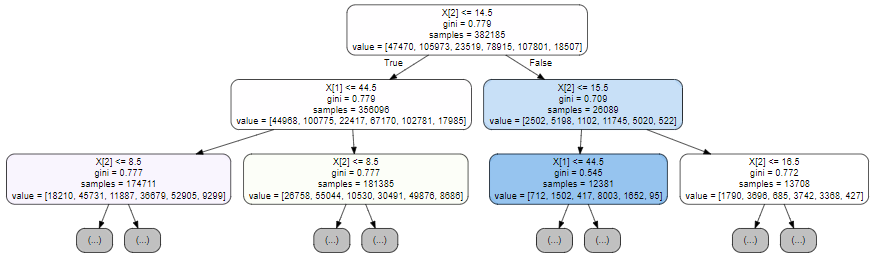

In [26]:
Image(filename = "../Imagenes/Arbol/arbolL2.png", height = 1200)

In [27]:
dotfile = open(".././PreparacionData/arboles/arbolL3.dot", 'w')
tree.export_graphviz(clasificador, out_file = dotfile, filled=True, rounded=True, max_depth = 3)
dotfile.close()

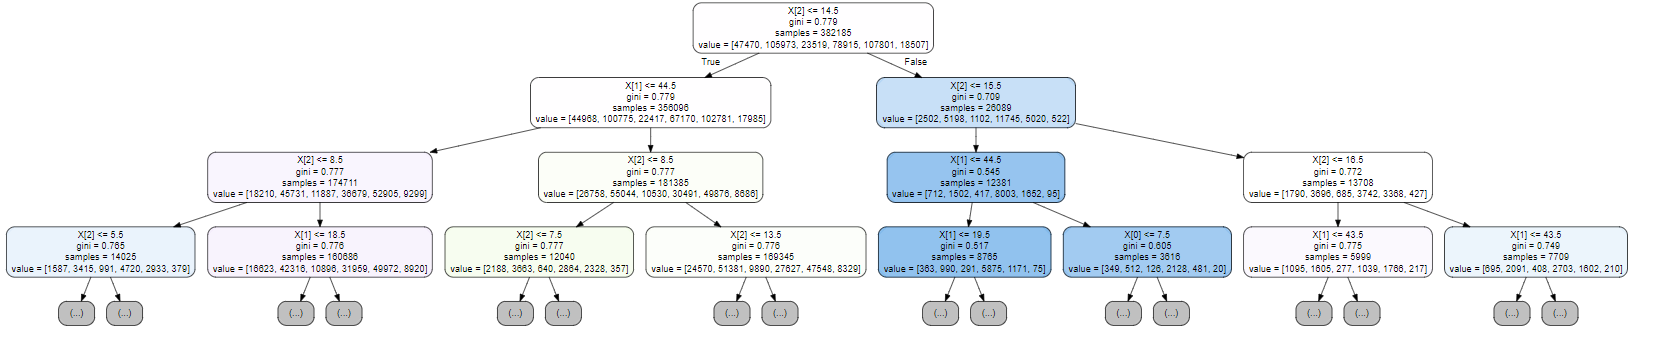

In [28]:
Image(filename = "../Imagenes/Arbol/arbolL3.png",  width=1300, height = 1200, unconfined=True)

In [29]:
fin = time.strftime("%c")
print ("La ejecución completa ha comprendido entre: " + inicio + ' y ' + fin)


La ejecución completa ha comprendido entre: Wed Jun 27 12:36:14 2018 y Wed Jun 27 12:37:40 2018
